### 불순도
+ 데이터 그룹 내 얼마나 다양한 객체가 있는지를 수치로 표현
+ 의사결정나무의 가지는 불순도가 낮은 방향으로 뻗어감
+ 불순도를 측정하는 지표는 CART, ID3/4.5/5, CHAID 등이 있고 각각의 알고리즘을 통해 얻을 수 있는 지표는 지니계수, 엔트로피 등이 있음

<img src='img/impurity.png'>

### 불순도 계산알고리즘 비교
+ CART : 보편적 알고리즘, 불순도 지표로 지니계수 사용, 계산속도빠름
+ ID3 : 범주형변수를 이용한 이함분류, 불순도 지표로 엔트로피 사용
    - C4.5 : 다항분류, 연속형변수를 이용한 회귀에도 사용가능
    - C5 : 저작권이 걸린 알고리즘, 앙상블트리 생성
+ CHAID : 통계적 분석 적용, 범주형변수는 카이제곱 검정을 연속형변수는 F검정을 통해 분류작업 수행


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree

#### 엔트로피
+ 물리 열역학에서의 관점
    - 물질의 열적 상태를 나타내는 물리량의 하나
    - 보통 무질서도라고 함
    - 엔트로피가 높으면 무질서도가 증가
+ 통계에서의 관점
    - 정보이득의 혼잡도/불순도
    - 엔트로피가 높으면 정보이해가 어려워짐
    - 즉, 정보의 불확실성을 수치로 나타낸 것
+ 학습 데이터는 기본적으로 혼잡한 상태
    - 따라서, 어떤 조건으로 분류해야만 전체 불순도가 개선되는지 계산
    - 정리한 결과에 대해 다시 계산해서 처리를 반복 적용

#### x = [1,2,3,4,5,6,7,8]
#### y = [0,0,0,1,1,1,1,1]
#### x를 기준으로 y를 나누는 가장 좋은 방법은?
+ 방법1) x = 3.5 (최적) 임계값
+ 방법2) x = 4.5 (오분류 가능성 존재)

#### 엔트로피 공식
+ $ entropy = -\sum p_k \log2 p_k $
+ 복수의 현상 n개가 존재할 때 그 불순도를 나타내는 엔트로피 식
    + -p(현상1) * log(p(현상1)) + -p(현상2) * log(p(현상2)) + ... + -p(현상n) * log(p(현상n))
+ 엔트로피는 일반적으로 2를 밑으로 하는 로그로 계산함

In [1]:
import math

#### 확률 0.1 현상이 10개 일어난 경우 엔트로피는?

In [5]:
-1 * (0.1 * math.log2(0.1)) * 10 

3.3219280948873626

#### 확률 0.25 현상이 4개 일어난 경우 엔트로피는?

In [8]:
-1 * (0.25* math.log2(0.25)) * 4

2.0

#### 데이터 상황별 불순도 확인 (빨간 공, 파란 공 비율)

In [182]:
dataa = [0, 10]
datab = [3, 7]
datac = [5, 5]

In [183]:
entropy([0,10], base=2) 

0.0

In [190]:
ep1 = (-1 * math.log2(1))* 0 + (-1 * math.log2(1)) * 10
ep1

-0.0

In [194]:
- 0 * np.log2(0) + - 10 * np.log2(10) 

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

In [192]:
(-3/10 * math.log2(3/10)) + (-7/10 * math.log2(7/10))

0.8812908992306927

In [184]:
entropy([3,7], base=2) 

0.8812908992306927

In [193]:
- 1/2 * math.log2(1/2) + - 1/2 * math.log2(1/2) 

1.0

In [185]:
entropy([5,5], base=2)

1.0

#### 3가지 특성에 따라 10마리 동물을 개/고양이로 분류

In [ ]:
# sales	   outlet	users	income	year	manager
# 37.702	1,739	9.27	85.4	3.5	    9.0
# 24.196	1,224	5.86	60.7	5.0	    5.0
# 32.055	1,846	8.81	68.1	4.4	    7.0
# 3.611	    120	    3.81	20.2	4.0	    5.0
# 17.625	1,096	10.31	33.8	3.5	    7.0
# 45.919	2,290	11.62	95.1	4.1	    13.0
# 29.600	1,687	8.96	69.3	4.1	    15.0
# 8.114	    241	    6.28	16.3	5.9	    11.0
# 20.116	649	    7.77	34.9	5.5	    16.0
# 12.994	1,427	10.92	15.1	4.1	    10.0


In [ ]:
# big   follow   walking      class

# yes     yes    yes          dog

# yes     yes    no           cat

# no      yes    yes          dog

# yes     yes    yes          dog

# no      no     yes          cat

# yes     no     yes          dog

# yes     no     yes          cat

# no      no     no           cat

# yes     yes    yes          dog

# no      yes    no           dog

#### 1) target 엔트로피 계산
+ 10마리 중 개는 6마리 고양이는 4마리
+ 개 확률 0.6 고양이 확률 0.4

#### (-0.6 * log2(0.6)) + (-0.4 * log2(0.4))

In [13]:
a = -0.6 * math.log2(0.6) 

In [12]:
b = -0.4 * math.log2(0.4)

In [14]:
a+b

0.9709505944546686

#### 불순도를 낮출 수 있는 분류기준이 필요

#### 2) 덩치 big으로 분류했을 때 엔트로피 계산
+ 덩치가 클때 개로 분류될 확률 : 0.667 (4/6)
+ 덩치가 클때 고양이로 분류될 확률 : 0.333 (2/6)

In [20]:
c= - 0.667 * math.log2(0.667)

In [21]:
d= -0.333 * math.log2(0.333)

In [22]:
c+d

0.9179621399872384

#### 덩치가 작은것으로 분류 = 걔 : 고양이 2:2
+ 덩치가 작을때 개로 분류될 확률 : 0.5 (2/4)
+ 덩치가 작을때 고양이로 분류될 확률 : 0.5 (2/4)

In [25]:
e= - 0.5 * math.log2(0.5)

In [28]:
f= -0.5 * math.log2(0.5)

In [29]:
e+f

1.0

#### 정보획득
+ 불순도 지표를 구할 수 있다면, 이를 통해 어떤 질문에서 얻을 수 있는 정보획득량을 계산할 수 있음
    + 어떤 기준에 따라 분할된 데이터에서 얻을 수 있는 정보획득량 비교
+ 생성된 크기에 따라 가중치를 구하고 이를 불순도에 곱함

#### 덩치로 분류했을때의 정보획득량은 
+ 개로 분류될 확률 X 덩치로 분류했을때의 불손도와 
+ 고양이로 분류될 확률 Y 덩치로 분류했을 때 불순도를 더한 결과값

In [37]:
6/10 * 0.9179621399872384 + 4/10 * 1.0

0.9507772839923431

#### 0.951 < 0.971 로 덩치를 기준으로 분류하는 것이 일반 분류확률보다 나음

#### 따름 여부로 분류 = 걔 : 고양이 5:1
+ 잘 따를 때 개로 분류될 확률 : 5/6
+ 잘 따를 때 고양이로 분류될 확률 : 1/6


#### 잘 안 따르는 개체 분류 : 1:3
+ 잘 안 따를 때 개로 분류될 확률 : 1/4
+ 잘 안 따를 때 고양이로 분류될 확률 : 3/4

In [42]:
g = - (5/6) * math.log2(5/6)

In [41]:
h = - (1/6) * math.log2(1/6)

In [43]:
g + h 

0.6500224216483541

In [44]:
j = - (1/4) * math.log2(1/4)

In [45]:
k = - (3/4) * math.log2(3/4)

In [46]:
j + k

0.8112781244591328

In [57]:
6/10 * 0.6500224216483541 + 4/10 * 0.8112781244591328

0.7145247027726656

#### 0.715 < 0.971 로 따름을 기준으로 분류하는 것이 일반 분류확률보다 나음

#### 산책 여부로 분류 = 걔 : 고양이 5:2
+ 산책할 때 개로 분류될 확률 : 5/7
+ 산책할 때 고양이로 분류될 확률 : 2/7


#### 산책 안하는 개체 분류 : 1:2
+ 산책 안할 때 개로 분류될 확률 : 1/3
+ 산책 안할 때 고양이로 분류될 확률 : 2/3

In [48]:
l = - (5/7) * math.log2(5/7)

In [49]:
m = - (2/7) * math.log2(2/7)

In [50]:
l + m

0.863120568566631

In [51]:
o = - (1/3) * math.log2(1/3)

In [52]:
p = - (2/3) * math.log2(2/3)

In [53]:
o + p

0.9182958340544896

In [59]:
6/10 * 0.863120568566631 + 4/10 * 0.9182958340544896

0.8851906747617744

#### 0.88 < 0.971 로 산책을 기준으로 분류하는 것이 일반 분류확률보다 나음

#### 덩치, 산책, 따름 여부에 따라 정보의 불순도 비교
+ 따름, 산책, 덩치 순으로 불순도가 낮으므로 그 순서대로 분류됨

### 개/고양이 분류를 의사결정나무로 분석

In [64]:
catdog = pd.read_csv('data/catdog.csv')

In [87]:
catdog['class'].value_counts()

dog    6
cat    4
Name: class, dtype: int64

#### 종속변수 빈도 확인

<AxesSubplot:xlabel='class', ylabel='count'>

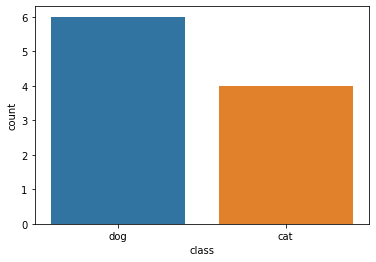

In [89]:
sns.countplot(x='class', data=catdog)

#### 데이터 전처리

In [91]:
cols = ['big','follow','walking','class']
for c in cols:
    catdog[c] = pd.Categorical(catdog[c])
    catdog[c] = catdog[c].cat.codes

#### 데이터 분리 및 분석

In [96]:
data = catdog.iloc[:, :3]
target = catdog['class']

In [97]:
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(data,target)
dtc.score(data, target)

0.9

#### 의사결정 시각화

In [98]:
dot_data = tree.export_graphviz(dtc, out_file=None, feature_names=cols[:3], class_names=['cat', 'dog'])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('img/catdog.png')

True

(-0.5, 710.5, 580.5, -0.5)

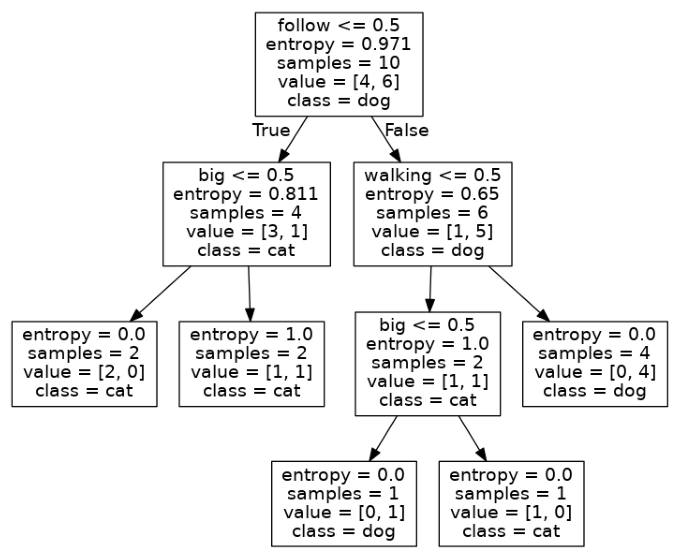

In [99]:
img = plt.imread('img/catdog.png')
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.axis('off')

### 날씨상황에 따른 골프실행 여부 분석

In [102]:
playgolf = pd.read_csv('data/playgolf.csv', sep='|')

In [103]:
playgolf.head()

,OUTLOOK,TEMPERATURE,HUMIDITY,WINDY,PLAY
0,sunny,85,85,False,Don'tPlay
1,sunny,80,90,True,Don'tPlay
2,overcast,83,78,False,Play
3,rain,70,96,False,Play
4,rain,68,80,False,Play


In [132]:
playgolf['OUTLOOK'].value_counts()

2    5
1    5
0    4
Name: OUTLOOK, dtype: int64

<AxesSubplot:xlabel='PLAY', ylabel='count'>

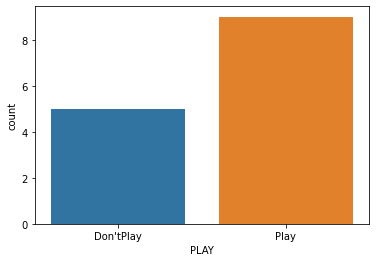

In [105]:
sns.countplot(x='PLAY', data=playgolf)

In [106]:
cols = ['OUTLOOK','TEMPERATURE','HUMIDITY','WINDY', 'PLAY']
for c in cols:
    playgolf[c] = pd.Categorical(playgolf[c])
    playgolf[c] = playgolf[c].cat.codes

In [107]:
playgolf

,OUTLOOK,TEMPERATURE,HUMIDITY,WINDY,PLAY
0,2,11,5,0,0
1,2,8,6,1,0
2,0,10,3,0,1
3,1,4,8,0,1
4,1,2,4,0,1
5,1,1,1,1,0
6,0,0,0,1,1
7,2,6,7,0,0
8,2,3,1,0,1
9,1,7,4,0,1


#### 데이터 분석

In [133]:
data2 = playgolf.iloc[:, :4]
target2 = playgolf['PLAY']

In [139]:
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
dtclf.fit(data2,target2)
dtclf.score(data2, target2)

0.9285714285714286

In [140]:
dot_data = tree.export_graphviz(dtclf, out_file=None, feature_names=cols[:4], class_names=["Don'tPlay", 'Play'])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('img/playgolf.png')

True

(-0.5, 627.5, 740.5, -0.5)

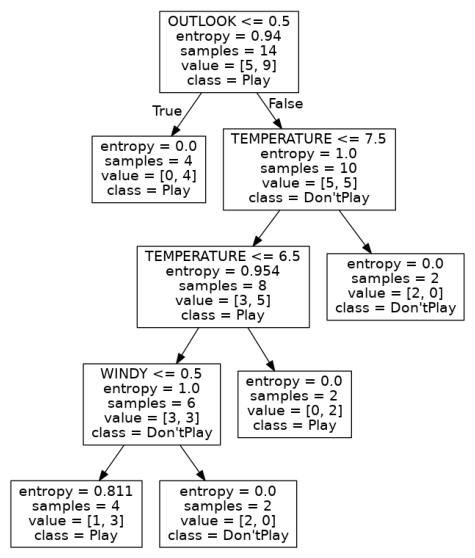

In [141]:
img = plt.imread('img/playgolf.png')
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.axis('off')

### 골프안칠 확률 : 5/14


In [121]:
nogo = -(5/14)  * math.log2(5/14)
nogo

0.5305095811322292

In [122]:
go = -(9/14)  * math.log2(9/14)
go

0.40977637753840174

In [123]:
(5/14) * 0.5305095811322292 + (9/14) * 0.40977637753840174

0.45289537882191155

#### 날씨 여부로 분류 = sunny : overcast : rain = 5 : 4 : 5
+ sunny 골프칠 확률 : 2/5
+ overcast 골프칠 확률 : 4/4
+ rain 골프칠 확률 : 3/5


In [116]:
sun = - (2/5) * math.log2(2/5)

In [114]:
sunn = - (3/5) * math.log2(3/5)

In [118]:
sun + sunn

0.9709505944546686

In [126]:
overcast = -1 * math.log2(1)
overcast

-0.0

In [127]:
rain = -(3/5) * math.log2(3/5)

In [128]:
rainn = -(2/5) * math.log2(2/5)

In [129]:
rain + rainn

0.9709505944546686

In [143]:
golf = pd.read_csv('data/playgolf.txt', sep=',')

In [144]:
golf.head()

,day,temp,outlook,humidity,windy,playGolf
0,5,hot,sunny,high,False,no
1,6,hot,sunny,high,True,no
2,7,hot,overcast,high,False,yes
3,9,cool,rain,normal,False,yes
4,10,cool,overcast,normal,True,yes


<AxesSubplot:xlabel='playGolf', ylabel='count'>

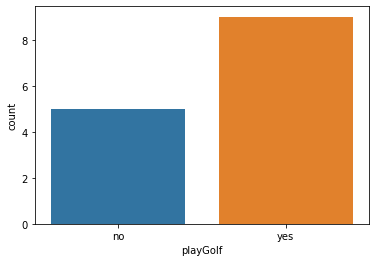

In [147]:
sns.countplot(x='playGolf', data=golf)

In [148]:
cols = ['day','temp','outlook','humidity','windy', 'playGolf']
for c in cols:
    golf[c] = pd.Categorical(golf[c])
    golf[c] = golf[c].cat.codes

In [149]:
golf

,day,temp,outlook,humidity,windy,playGolf
0,0,1,2,0,0,0
1,1,1,2,0,1,0
2,2,1,0,0,0,1
3,3,0,1,1,0,1
4,4,0,0,1,1,1
5,5,2,2,0,0,0
6,6,0,2,1,0,1
7,7,2,1,1,0,1
8,8,2,2,1,1,1
9,9,2,0,0,1,1


In [165]:
data3 = golf.iloc[:, 1:5]
target3 = golf['playGolf']

In [166]:
dtcl = DecisionTreeClassifier(criterion='entropy', max_depth = 3)
dtcl.fit(data3,target3)
dtcl.score(data3, target3)

0.8571428571428571

In [168]:
dot_data = tree.export_graphviz(dtcl, out_file=None, feature_names=cols[1:5], class_names=["NO", 'YES'])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('img/golf.png')

True

(-0.5, 712.5, 580.5, -0.5)

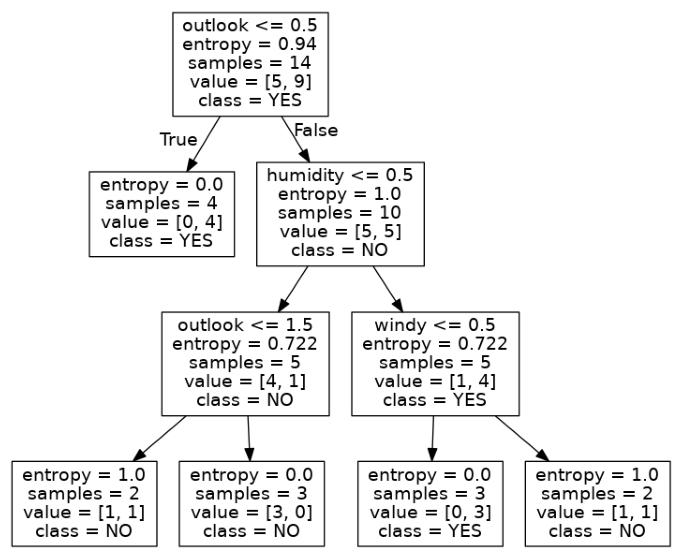

In [169]:
img = plt.imread('img/golf.png')
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.axis('off')

### 엔트로피 계산 편리하게 하기
+ #### entropy([이벤트수, ,...], 로그밑수}

In [171]:
from scipy.stats import entropy

#### 고양이와 개로 분류될 확률 = 4:6

In [174]:
entropy([4,6], base=2)  # base - log2

0.9709505944546688

#### 날씨상황에 따른 골프 실행 엔트로피 계산
+ 14개 날씨 데이터 중 골프 침/골프 안 침 횟수 - 9:5

In [179]:
- (9/14) * math.log2(9/14) + -(5/14) * math.log2(5/14)

0.9402859586706309

In [180]:
entropy([9,5], base=2)  # 0.940

0.940285958670631

In [ ]:
- (9/14) * math.log2(9/14) + -(5/14) * math.log2(5/14)

In [181]:
entropy([5,4,5], base=2)

1.5774062828523454